In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_mnist

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [ ]:
# max_seq_len = 64
# batch_size = 64
# dataset_size = 2000
# with_mask = False

# train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_train_10k.csv",
#                                                                                                  with_mask=with_mask,
#                                                                                                  split_ratio=0.2,
#                                                                                                  dataset_size=dataset_size,
#                                                                                                  max_seq_len=max_seq_len,
#                                                                                                  train=True)

# test_tokens, test_labels, test_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_test_2k.csv",
#                                                             with_mask=with_mask,
#                                                             max_seq_len=max_seq_len,
#                                                             dataset_size=500,
#                                                             train=False)

# train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [189]:
import numpy as np

batch_size = 64
loaded = np.load("dataset/train_mnist_10k.npz")

train_tokens, train_labels = loaded['train_tokens'][:2000], loaded['train_labels'][:2000]
val_tokens, val_labels = loaded['train_tokens'][2000:2500], loaded['train_labels'][2000:2500]

train_tokens = torch.tensor(train_tokens, dtype=torch.float32)
val_tokens = torch.tensor(val_tokens, dtype=torch.float32)
train_labels= torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tokens, val_labels), batch_size=32)

In [202]:
class ConvAE(nn.Module):
    def __init__(self, fea_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv1d(fea_dim, 16, kernel_size=3, padding=1, stride=2),
                                     nn.ReLU(),
                                     nn.Conv1d(16, 8, kernel_size=3, padding=1, stride=2),
                                     nn.ReLU(),
                                     nn.Conv1d(8, 4, kernel_size=3, padding=1, stride=1),)
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(4, 8, kernel_size=3, padding=1, stride=1, output_padding=0),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(8, 16, kernel_size=3, padding=1, stride=2, output_padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(16, fea_dim, kernel_size=3, padding=1, stride=2, output_padding=1))
        # self.relu = nn.ReLU()

        self.mse_loss_func = nn.MSELoss()
        self.meta_loss_func = nn.CrossEntropyLoss()
        
    def forward(self, x):

        permuated_x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, seq_len)
        encoded = self.encoder(permuated_x)
        decoded = self.decoder(encoded)

        decoded = decoded.permute(0, 2, 1)

        coord_output = decoded[:, :, :2]
        meta_output1 = decoded[:, :, 2:4]
        meta_output2 = decoded[:, :, 4:]
        target_meta1 = torch.argmax(x[:, :, 2:4], dim=-1) # inner or outer points
        target_meta2 = torch.argmax(x[:, :, 4:], dim=-1) # render one-hot code
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2])
        # 2 is inner or outer one-hot vocab size, 3 is render one-hot vocab size
        meta_loss1 = self.meta_loss_func(meta_output1.contiguous().view(-1, 2), target_meta1.contiguous().view(-1))
        meta_loss2 = self.meta_loss_func(meta_output2.contiguous().view(-1, 3), target_meta2.contiguous().view(-1))

        meta_indices1 = torch.argmax(meta_output1, dim=-1)
        meta_indices2 = torch.argmax(meta_output2, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices1, 2), nn.functional.one_hot(meta_indices2, 3)], dim=-1)

        return encoded, output, coord_loss*0.25 + (meta_loss1 + meta_loss2)*0.75

In [203]:
cae = ConvAE(7)
optimizer = optim.Adam(cae.parameters(), lr=0.004)

num_epoch = 50

for epoch in range(num_epoch):
    cae.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        hidden, outputs, loss = cae(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    cae.eval()
    with torch.no_grad():
        val_hidden, val_outputs, loss = cae(val_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 0.8907811007802449, Val Loss: 0.5487638711929321
Epoch 2, Train Loss: 0.30703724826139117, Val Loss: 0.1389029622077942
Epoch 3, Train Loss: 0.10225968772456759, Val Loss: 0.07935222238302231
Epoch 4, Train Loss: 0.06350439917000514, Val Loss: 0.050690021365880966
Epoch 5, Train Loss: 0.04325751611401164, Val Loss: 0.03687690943479538
Epoch 6, Train Loss: 0.03259125215903161, Val Loss: 0.031808748841285706
Epoch 7, Train Loss: 0.026149319189171943, Val Loss: 0.022395800799131393
Epoch 8, Train Loss: 0.02019211787375666, Val Loss: 0.0170304998755455
Epoch 9, Train Loss: 0.017522775612416722, Val Loss: 0.014868071302771568
Epoch 10, Train Loss: 0.014226479219302299, Val Loss: 0.012791655957698822
Epoch 11, Train Loss: 0.013044532181488143, Val Loss: 0.012071482837200165
Epoch 12, Train Loss: 0.011699741972344262, Val Loss: 0.011174023151397705
Epoch 13, Train Loss: 0.011163063236467895, Val Loss: 0.010085197165608406
Epoch 14, Train Loss: 0.010009302018535516, Val Lo

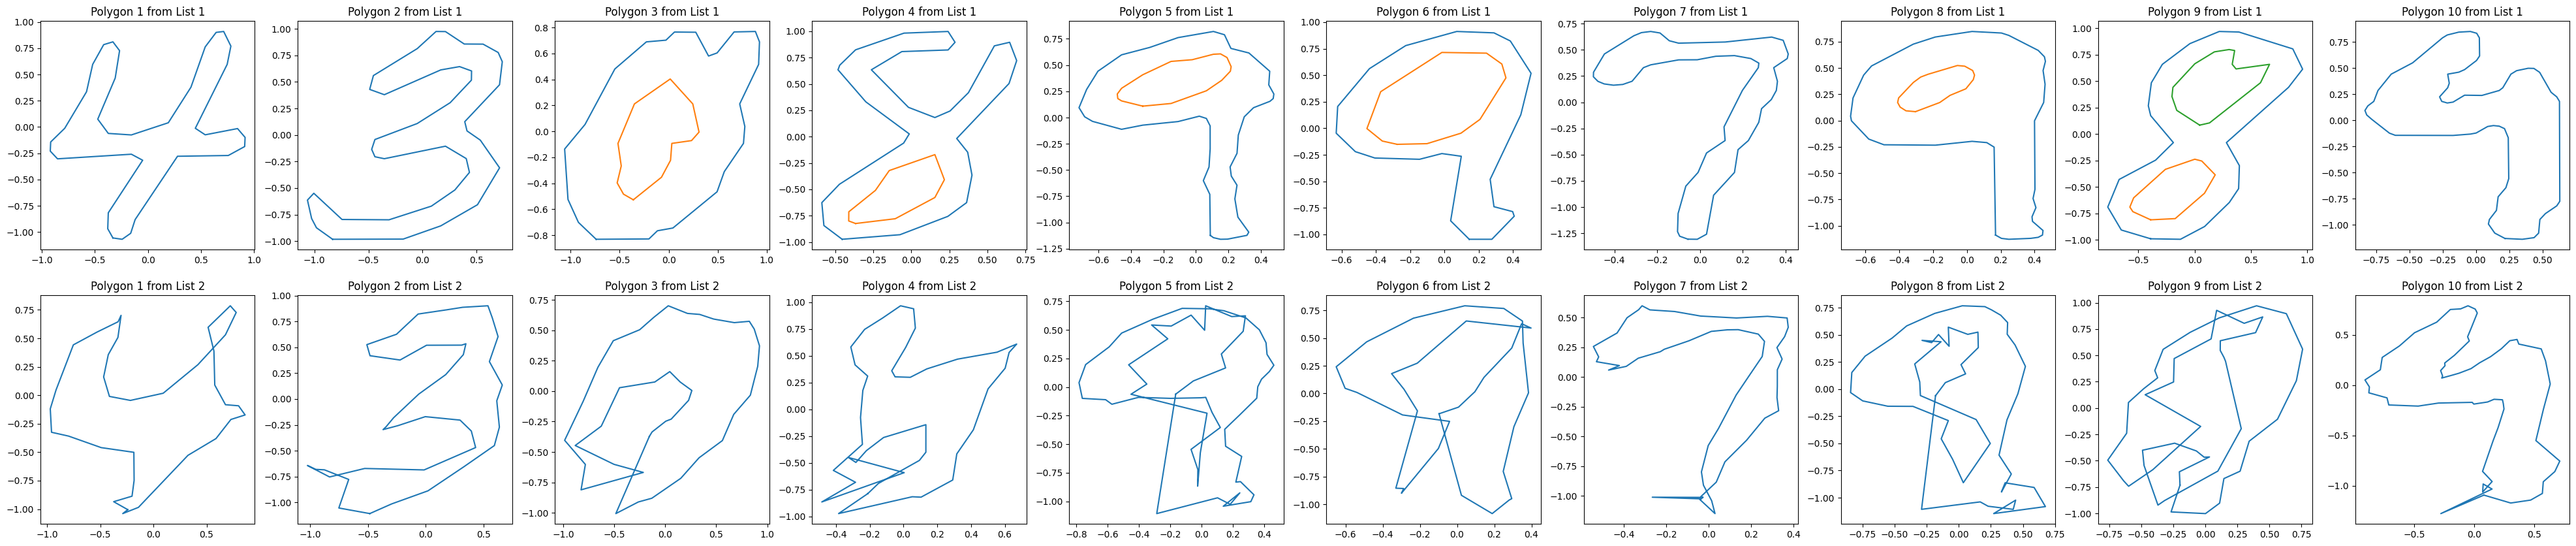

In [204]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

show_tokens = val_tokens[:10]

cae.eval()
with torch.no_grad():
    show_hidden, show_outputs, _ = cae(show_tokens)

num_samples = 10
ori_polygons = [reverse_vector_polygon(token) for token in show_tokens]
new_polygons = [reverse_vector_polygon(token) for token in show_outputs]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[0, i].plot(hole_x, hole_y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[1, i].plot(hole_x, hole_y)

# Show the plot
plt.show()

In [ ]:
import numpy as np
import utils.geom_scaler as geom_scaler

dataset_size = 1000
file = "dataset/buildings_train_v8.npz"
normalize = True

loaded = np.load(file)
geoms = loaded['fixed_size_geoms']
geom_types = loaded['building_type']
if dataset_size is not None:
    fixed_size_geoms = geoms[:dataset_size]
    geom_types = geom_types[:dataset_size]
if normalize:
    geom_scale = geom_scaler.scale(geoms)
    geoms = geom_scaler.transform(geoms, geom_scale)

polygon_dict = {}
for token, label in zip(geoms, geom_types):
    if label in polygon_dict:
        polygon_dict[label].append(token)
    else:
        polygon_dict[label] = [token]

from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

num_samples = 10

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(9, num_samples, figsize=(5*num_samples, 5*9))

for j, label in enumerate(list(polygon_dict.keys())):
    # Plot polygons from the first list
    for i, geom_vec in enumerate(polygon_dict[label][:10]):
        axs[j, i].set_title('Polygon {} from {}'.format(i+1, label))
        polygon = reverse_vector_polygon(geom_vec)
        x, y = polygon.exterior.xy
        axs[j, i].plot(x, y)

# Show the plot
plt.show()

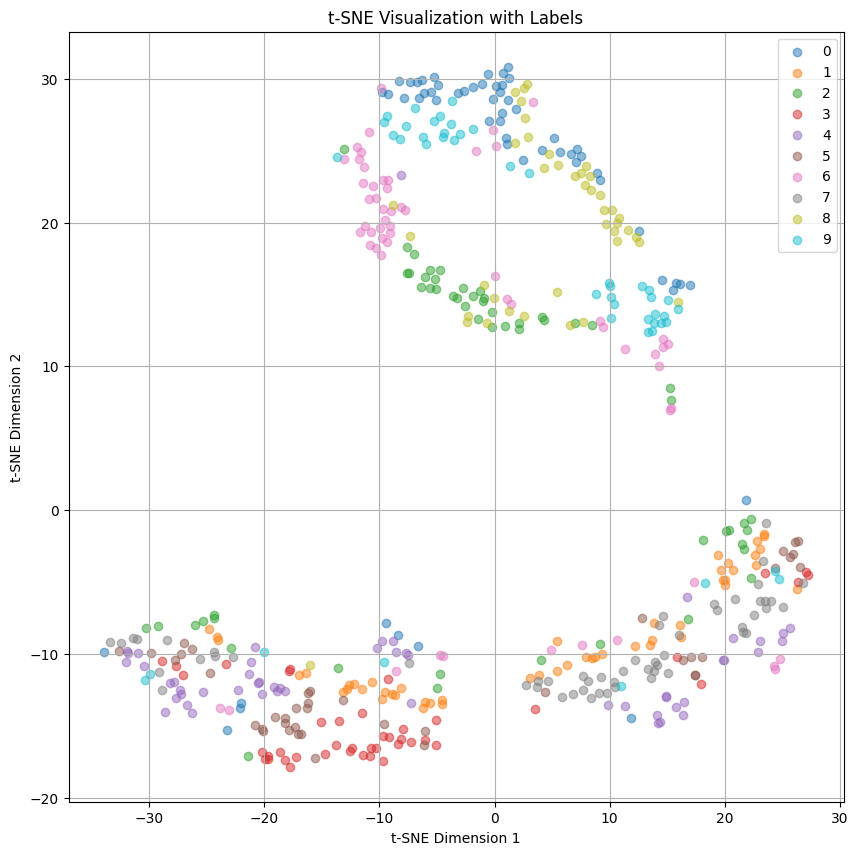

In [205]:
# show_hidden = val_tokens.view(val_tokens.size(0), -1)
show_hidden = val_hidden.view(val_hidden.size(0), -1)
show_labels = val_labels


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(show_hidden)

plt.figure(figsize=(10, 10))

# Plot each class separately
for label in np.unique(show_labels):
    indices = show_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [206]:
cae.eval()
with torch.no_grad():
    train_hidden = cae(train_tokens)[0].view(train_tokens.size(0), -1)
    val_hidden = cae(val_tokens)[0].view(val_tokens.size(0), -1)


    # tsne = PCA(n_components=64, random_state=0)
    # train_hidden = torch.tensor(tsne.fit_transform(train_hidden), dtype=torch.float32)
    # val_hidden = torch.tensor(tsne.transform(val_hidden), dtype=torch.float32)

# # Without encoding
# train_hidden = train_tokens.view(train_tokens.size(0), -1)
# val_hidden = val_tokens.view(val_tokens.size(0), -1)

cls_train_loader = DataLoader(TensorDataset(train_hidden, train_labels), batch_size=batch_size, shuffle=True)

In [207]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        # x = self.relu(self.dense1(x))
        # x = self.dropout(x)
        # x = self.dense2(x)
        # Linear probing
        x = self.dense1(x)
        return x
    
classifier = Classifier(train_hidden.size(1), 128, 10, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(classifier.parameters(), lr=0.004)
optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 30

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, cls_train_loader)
    val_loss, val_acc = evaluate(classifier, val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 4.378374695777893, Train Acc 0.2255, Val Loss: 2.1171228885650635, Val Acc: 0.342
Epoch: 2, Train Loss: 1.9454346597194672, Train Acc 0.4005, Val Loss: 1.5964182615280151, Val Acc: 0.468
Epoch: 3, Train Loss: 1.6090000234544277, Train Acc 0.4865, Val Loss: 1.4504315853118896, Val Acc: 0.528
Epoch: 4, Train Loss: 1.4767715986818075, Train Acc 0.535, Val Loss: 1.3438533544540405, Val Acc: 0.57
Epoch: 5, Train Loss: 1.3678738214075565, Train Acc 0.5715, Val Loss: 1.2293447256088257, Val Acc: 0.594
Epoch: 6, Train Loss: 1.3194237872958183, Train Acc 0.592, Val Loss: 1.2940709590911865, Val Acc: 0.61
Epoch: 7, Train Loss: 1.2705591544508934, Train Acc 0.618, Val Loss: 1.1556129455566406, Val Acc: 0.664
Epoch: 8, Train Loss: 1.3356694392859936, Train Acc 0.5825, Val Loss: 1.1749677658081055, Val Acc: 0.618
Epoch: 9, Train Loss: 1.256741663441062, Train Acc 0.6145, Val Loss: 1.0294779539108276, Val Acc: 0.69
Epoch: 10, Train Loss: 1.1848941911011934, Train Acc 0.638, Val

In [208]:
labels_array = val_labels.numpy()
length = labels_array.shape[0]
# Find unique classes and their frequencies
unique_classes, class_counts = np.unique(labels_array, return_counts=True)
fre_dict = {c: count/length for c, count in zip(unique_classes, class_counts)}
fre_dict

{0: 0.114,
 1: 0.1,
 2: 0.11,
 3: 0.086,
 4: 0.104,
 5: 0.082,
 6: 0.118,
 7: 0.11,
 8: 0.082,
 9: 0.094}